In [ ]:
# Importa modulos en Google Colab. OJO: Ejecutar dos veces.

import os # Configura GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importar Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
# Importa modulos en entorno local. OJO: No ejecutar en Google Colab.

import sionna

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0=INFO,1=WARNING,2=ERROR,3=FATAL


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

2026-01-15 20:17:49.973380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768526270.052134    3243 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768526270.072396    3243 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768526270.263986    3243 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768526270.264018    3243 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768526270.264019    3243 computation_placer.cc:177] computation placer alr

In [2]:
# Parametros generales

sionna.phy.config.seed = 0 # semilla para reproducibilidad
N = 128 # longitud del código
K = 64 # número de bits de información (antes de CRC)
bitsxsimb = 1 # bits por símbolo (BPSK)
list_scl = 8 # tamaño de lista para SCL
LLR_clip = 500 # valor de recorte para LLRs

# Parametros de ploteo
EBNO_DB_MIN = 0 # Eb/N0 mínimo en dB para ploteo
EBNO_DB_MAX = 25 # Eb/N0 máximo en dB para ploteo
LOTE = 500 # tamaño de lote para ploteo

I0000 00:00:1768526277.012068    3243 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9579 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Canal Rayleigh
@tf.function(jit_compile=True)
def canalRayleigh(ebno_db, bitsxsimb, coderate, x):
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate)
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag)
    h_real = sionna.phy.config.tf_rng.normal(tf.shape(x), stddev=tf.sqrt(0.5), dtype=tf.float32)
    h_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), stddev=tf.sqrt(0.5), dtype=tf.float32)
    h = tf.complex(h_real, h_imag)
    y = h * x + awgn
    return no, h, y

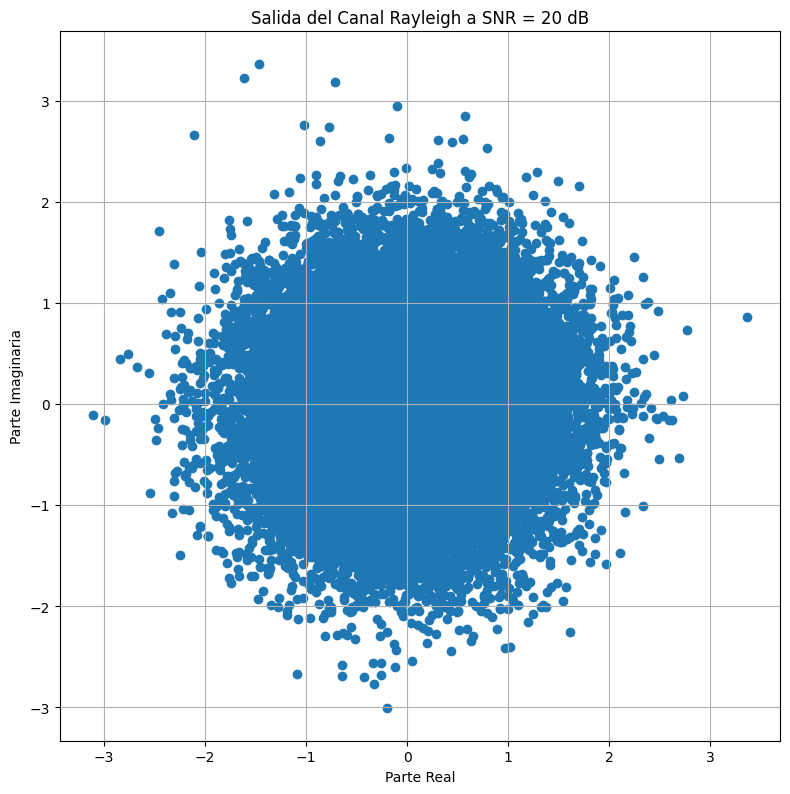

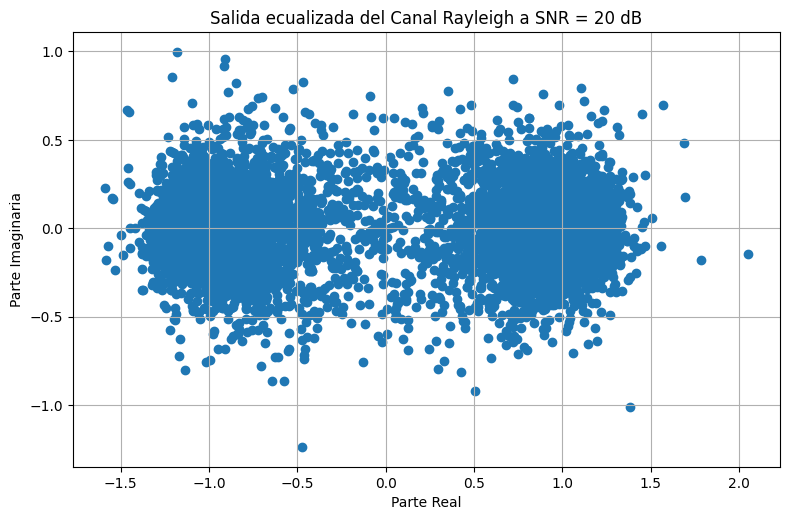

In [5]:
# Prueba el correcto funcionamiento del sistema con canal Rayleigh

# Bloques de transmision
snr_prueba = 20 # SNR de prueba en dB
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb) # para mas bitsxsimb usar "qam"
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador_llr = sionna.phy.mapping.Demapper("app", constellation=constelacion)
demapeador_hard = sionna.phy.mapping.Demapper("app", constellation=constelacion, hard_out=True)
b = datos([LOTE, K])
x = mapeador(b)

# Canal Rayleigh con fading plano por bloque
no, h, y = canalRayleigh(snr_prueba, bitsxsimb, coderate=1.0, x=x)

# Bloques de recepcion
mmse = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
y_eq = mmse * y
no_eff = no * tf.math.square(tf.abs(mmse))
llr = demapeador_llr(y_eq, no_eff)
b_hat = demapeador_hard(y_eq, no_eff)

# Grafico de y
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Grafico de y ecualizado
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida ecualizada del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y_eq), tf.math.imag(y_eq))
plt.tight_layout()

# Verificar dimensiones y valores de las variables luego de la ejecucion

In [7]:
# Prueba de variables

print("x:", x[0, :3])
print("h:", h[0, :3])
print("y:", y[0, :3])
print("y_eq:", y_eq[0, :3])
print("llr:", llr[0, :3])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))

x: tf.Tensor([-1.+0.j -1.+0.j  1.+0.j], shape=(3,), dtype=complex64)
h: tf.Tensor([ 0.19831799-0.2616657j  -0.14236529+1.0788901j  -0.01236856+0.34034032j], shape=(3,), dtype=complex64)
y: tf.Tensor([-0.13650934+0.29218948j  0.07525619-1.1976631j   0.05651597+0.41689536j], shape=(3,), dtype=complex64)
y_eq: tf.Tensor([-0.8788551+0.18868259j -1.0909247+0.07478407j  1.1206717-0.19360363j], shape=(3,), dtype=complex64)
llr: tf.Tensor([ 45.25282 525.5448  -61.3441 ], shape=(3,), dtype=float32)
err: 71


In [8]:
# Define la clase del sistema sin código de canal

class SinCodigRayleigh(sionna.phy.Block):
    def __init__(self, N, bitsxsimb):
        super().__init__()
        self.N = N
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("pam", self.bitsxsimb) # para mas bitsxsimb usar "qam"
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.N])
        x = self.mapeador(b)
        
        # Canal Rayleigh
        no, h, y = canalRayleigh(ebno_db, self.bitsxsimb, coderate=1.0, x=x)

        # Bloques de recepcion
        mmse = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
        y_eq = mmse * y
        no_eff = no * tf.math.square(tf.abs(mmse))
        llr = tf.clip_by_value(self.demapeador(y_eq, no_eff), -LLR_clip, LLR_clip)

        return b, llr

In [9]:
# Se inicializa la clase con parametros generales

sin_codigo_rayleigh = SinCodigRayleigh(K, bitsxsimb) # K, porque N es valor con codigo de canal

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4722e-01 | 1.0000e+00 |        4711 |       32000 |          500 |         500 |         1.1 |reached target block errors
      1.0 | 1.2550e-01 | 1.0000e+00 |        4016 |       32000 |          500 |         500 |         0.0 |reached target block errors
      2.0 | 1.0994e-01 | 1.0000e+00 |        3518 |       32000 |          500 |         500 |         0.0 |reached target block errors
      3.0 | 8.6688e-02 | 9.9600e-01 |        2774 |       32000 |          498 |         500 |         0.0 |reached target block errors
      4.0 | 7.7938e-02 | 9.9800e-01 |        2494 |       32000 |          499 |         500 |         0.0 |reached target block errors
      5.0 | 6.3687e-02 | 9.8000e-01 |        2038 |       32000 |

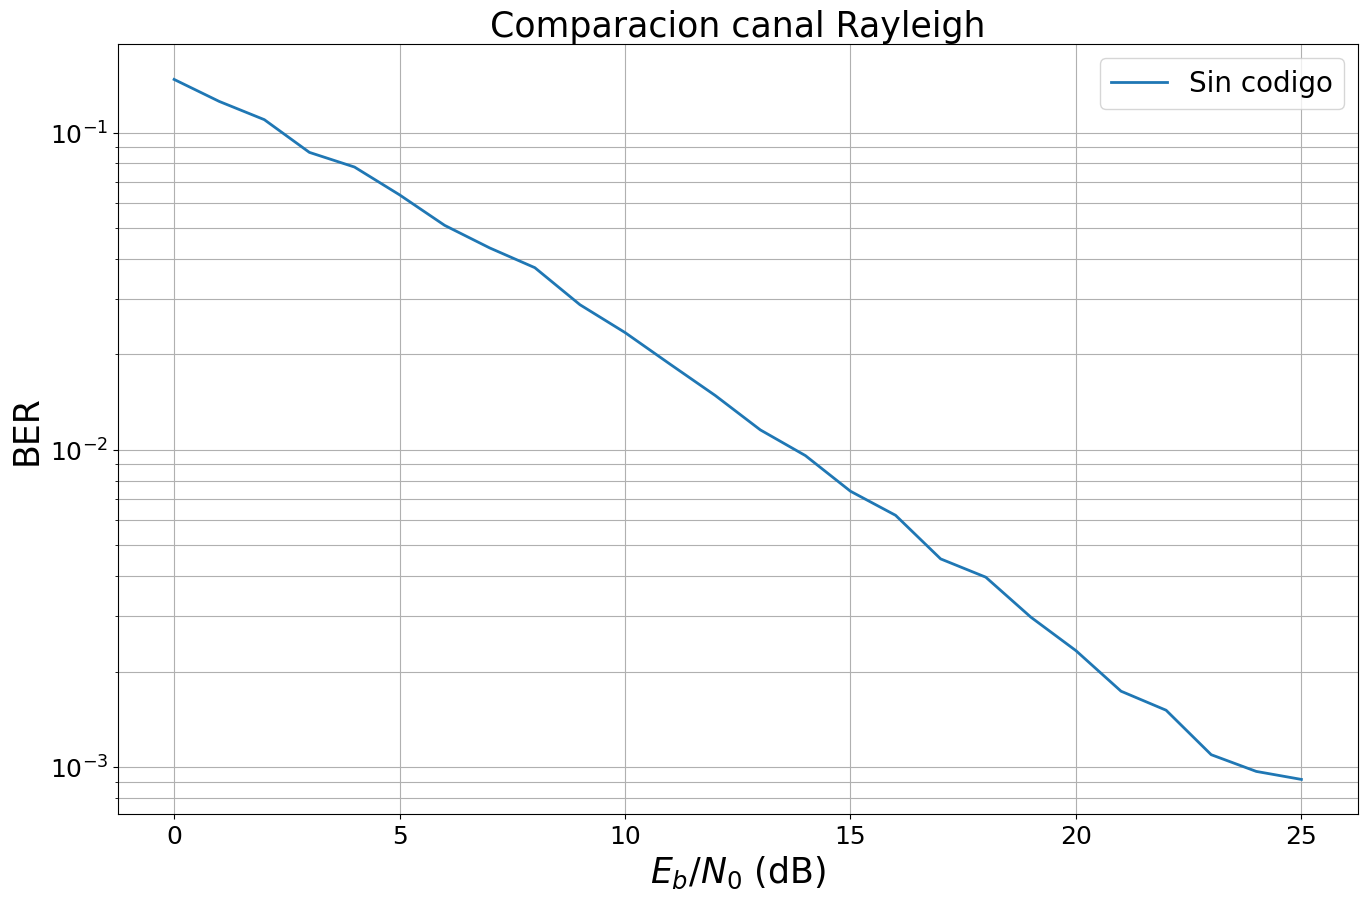

In [10]:
# Simulación y ploteo de BER

ber_plots = sionna.phy.utils.PlotBER("Comparacion canal Rayleigh")
ber_plots.simulate(sin_codigo_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_DB_MAX - EBNO_DB_MIN + 1),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [11]:
# Generador Monte Carlo de bits congelados con XLA acceleration

# Función compilada XLA para simulacion de batch_size
@tf.function(jit_compile=True)
def simulacion_batch_size(snr_prueba, bitsxsimb, batch_size, datos, codificador, mapeador, demapeador, decodificador):
    # Bloques de transmision
    bits = datos([batch_size, 1]) # solo 1 bit de datos por bit-canal
    bits_codif = codificador(bits) # codifica a N bits
    x = mapeador(bits_codif)

    # Canal Rayleigh
    no, h, y = canalRayleigh(snr_prueba, bitsxsimb, coderate=1.0/N, x=x) # solo 1 bit de datos por bit-canal

    # Bloques de recepcion
    mmse = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
    y_eq = mmse * y
    no_eff = no * tf.math.square(tf.abs(mmse))
    llr = tf.clip_by_value(demapeador(y_eq, no_eff), -LLR_clip, LLR_clip)
    bits_decodif = decodificador(llr)

    # Cálculo de errores y borrado de variables intermedias
    err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
    del bits, bits_codif, x, y, y_eq, llr, bits_decodif
    
    return tf.cast(err, tf.int64), tf.constant(batch_size, dtype=tf.int64)

# Parámetros de la simulacion
batch_size = 2000 # Emplea la VRAM de la GPU
num_iter = 10000 # Itera para incrementar simulaciones por bit-canal
# Info: Cada bit-canal se simula batch_size * num_iter veces
snr_prueba = 12.0 # Se observa similar BER que 4.0 dB en canal AWGN

# Inicializa los bloques necesarios
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)

for i in range(N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y reinicia conteo errores
    bits_congelados = np.array([j for j in range(N) if j != i]) # se analiza cada bit-canal
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=list_scl)
    errores_totales = 0
    bits_totales = 0

    # Se itera varias veces para acumular errores
    for b in range(num_iter):
        # Ejecuta iteración compilada con XLA
        err, total = simulacion_batch_size(snr_prueba, bitsxsimb, batch_size, datos, codificador, mapeador, demapeador, decodificador)
        errores_totales += int(err.numpy())
        bits_totales += int(total.numpy())

    print()
    BER_bits[i] = errores_totales / bits_totales

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

Procesando bit-canal 1/128

2026-01-15 20:23:44.915307: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %transpose.71 = f32[2000,16,112]{2,1,0} transpose(f32[112,2000,16]{2,1,0} %constant.1199), dimensions={1,2,0}, metadata={op_type="GatherV2" op_name="GatherV2_29" source_file="/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2026-01-15 20:23:44.937429: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.898862167s
Constant folding an instruction is taking > 1s:


Procesando bit-canal 2/128
Procesando bit-canal 3/128
Procesando bit-canal 4/128
Procesando bit-canal 5/128
Procesando bit-canal 6/128
Procesando bit-canal 7/128
Procesando bit-canal 8/128
Procesando bit-canal 9/128
Procesando bit-canal 10/128
Procesando bit-canal 11/128
Procesando bit-canal 12/128
Procesando bit-canal 13/128
Procesando bit-canal 14/128
Procesando bit-canal 15/128
Procesando bit-canal 16/128
Procesando bit-canal 17/128
Procesando bit-canal 18/128
Procesando bit-canal 19/128
Procesando bit-canal 20/128
Procesando bit-canal 21/128
Procesando bit-canal 22/128
Procesando bit-canal 23/128
Procesando bit-canal 24/128
Procesando bit-canal 25/128
Procesando bit-canal 26/128
Procesando bit-canal 27/128
Procesando bit-canal 28/128
Procesando bit-canal 29/128
Procesando bit-canal 30/128
Procesando bit-canal 31/128

2026-01-15 20:33:24.826986: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 2s:

  %gather.16 = f32[64,1,2000,16]{3,2,1,0} gather(f32[128,2000,16]{2,1,0} %broadcast.867, s64[64,1]{1,0} %constant.980), offset_dims={1,2,3}, collapsed_slice_dims={}, start_index_map={0}, index_vector_dim=1, slice_sizes={1,2000,16}, metadata={op_type="GatherV2" op_name="GatherV2_19" source_file="/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2026-01-15 20:33:24.834678: E external/local_xla/x


Procesando bit-canal 32/128
Procesando bit-canal 33/128
Procesando bit-canal 34/128
Procesando bit-canal 35/128
Procesando bit-canal 36/128
Procesando bit-canal 37/128
Procesando bit-canal 38/128
Procesando bit-canal 39/128
Procesando bit-canal 40/128
Procesando bit-canal 41/128
Procesando bit-canal 42/128
Procesando bit-canal 43/128
Procesando bit-canal 44/128
Procesando bit-canal 45/128
Procesando bit-canal 46/128
Procesando bit-canal 47/128
Procesando bit-canal 48/128
Procesando bit-canal 49/128
Procesando bit-canal 50/128
Procesando bit-canal 51/128
Procesando bit-canal 52/128
Procesando bit-canal 53/128
Procesando bit-canal 54/128
Procesando bit-canal 55/128
Procesando bit-canal 56/128
Procesando bit-canal 57/128
Procesando bit-canal 58/128
Procesando bit-canal 59/128
Procesando bit-canal 60/128
Procesando bit-canal 61/128
Procesando bit-canal 62/128
Procesando bit-canal 63/128
Procesando bit-canal 64/128
Procesando bit-canal 65/128
Procesando bit-canal 66/128
Procesando bit-cana

In [12]:
# Bloque de guardado de variables de simulacion Monte Carlo
# Asume batch_size siempre es 2000 (por uso de la VRAM)

output_dir = "resultados"
os.makedirs(output_dir, exist_ok=True)
df = pd.DataFrame({"BER bits": BER_bits})
filename = os.path.join(output_dir,f"Rayleigh_hxsimb_BER_bits_{N}_{K}_{num_iter}.csv")
df.to_csv(filename, index=True)

In [ ]:
# Bloque de recupero de variables de simulacion Monte Carlo
# Asume batch_size siempre es 2000 (por uso de la VRAM)

output_dir = "resultados"
num_iter = 1000 # OJO: debe coincidir con el usado en la simulacion
filename = os.path.join(output_dir,f"Rayleigh_hxsimb_BER_bits_{N}_{K}_{num_iter}.csv")
df = pd.read_csv(filename)
BER_bits = df["BER bits"].to_numpy()
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

In [14]:
# Define la clase del sistema con código polar

class CodPolarRayleigh(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, lista_SCL, bitsxsimb):
        super().__init__()
        self.N = N
        self.K = K
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.constelacion = sionna.phy.mapping.Constellation("pam", self.bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.K])
        bits_codif = self.polar_codif(b)
        x = self.mapeador(bits_codif)

        # Canal Rayleigh
        no, h, y = canalRayleigh(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)

        # Bloques de recepcion
        mmse = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
        y_eq = mmse * y
        no_eff = no * tf.math.square(tf.abs(mmse))
        llr = self.demapeador(y_eq, no_eff)
        b_hat = self.polar_decodif(llr)

        return b, b_hat

In [15]:
# Se inicializa la clase con los bits congelados obtenidos por Monte Carlo y parametros generales

cod_polar_rayleigh = CodPolarRayleigh(N, K, bits_congelados, list_scl, bitsxsimb)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.6706e-01 | 9.9900e-01 |       29892 |       64000 |          999 |        1000 |         4.3 |reached target block errors
      1.0 | 4.3638e-01 | 9.7900e-01 |       27928 |       64000 |          979 |        1000 |         2.0 |reached target block errors
      2.0 | 3.9550e-01 | 9.3700e-01 |       25312 |       64000 |          937 |        1000 |         2.1 |reached target block errors
      3.0 | 3.1489e-01 | 8.2300e-01 |       20153 |       64000 |          823 |        1000 |         2.1 |reached target block errors
      4.0 | 2.3317e-01 | 6.6100e-01 |       14923 |       64000 |          661 |        1000 |         2.2 |reached target block errors
      5.0 | 1.3564e-01 | 4.1533e-01 |       13021 |       96000 |

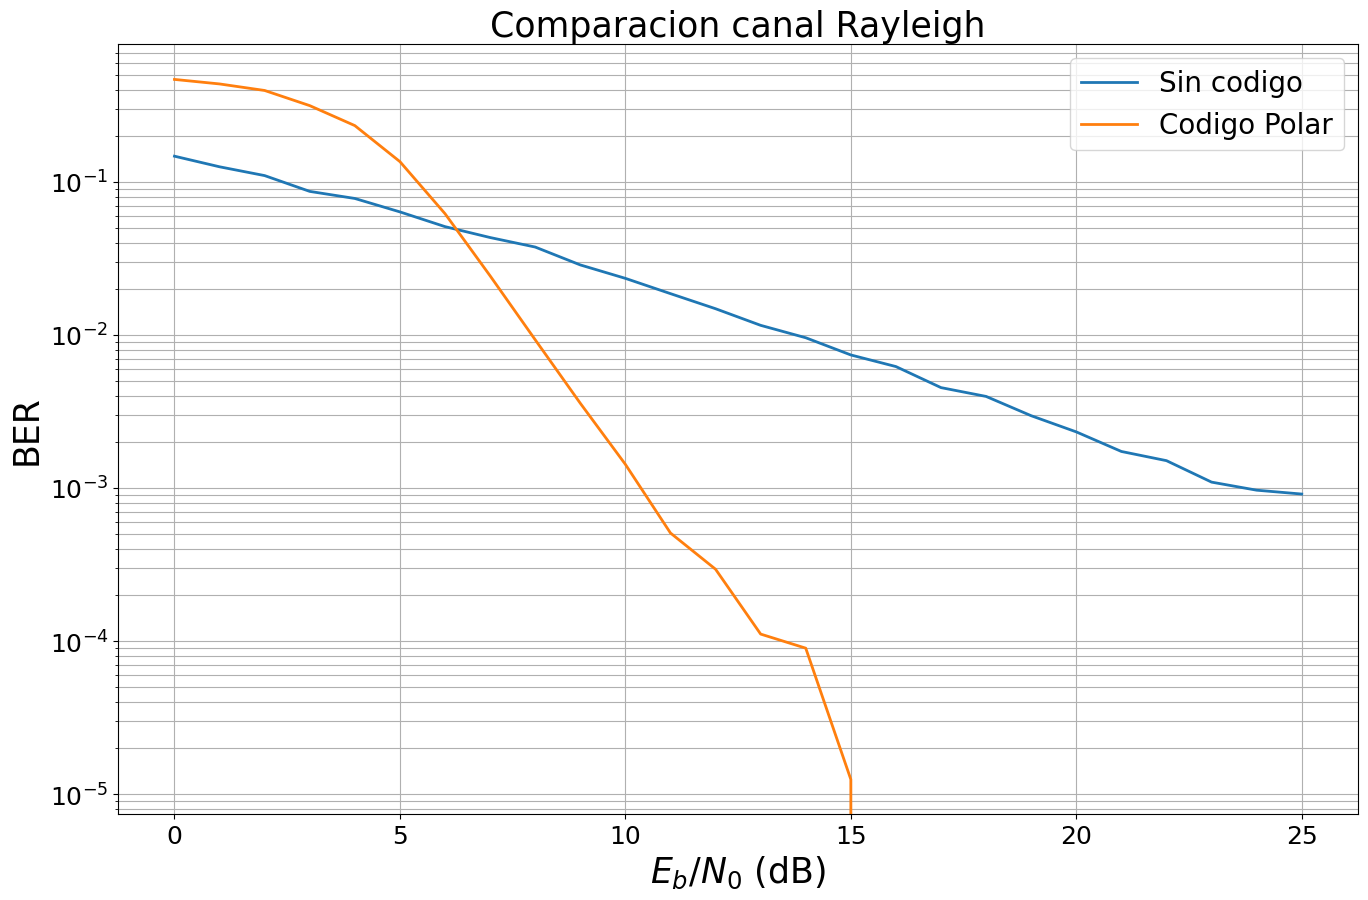

In [16]:
# Ploteo de la tasa de error para Codigo Polar

ber_plots.simulate(cod_polar_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_DB_MAX - EBNO_DB_MIN + 1),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);